In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Read csv file

In [134]:
df = pd.read_csv('fifa_players.csv')
df['id'] = df.index
df.set_index('id', inplace=True)
df.head()

,name,full_name,birth_date,age,height_cm,weight_kgs,positions,nationality,overall_rating,potential,value_euro,wage_euro,preferred_foot,international_reputation(1-5),weak_foot(1-5),skill_moves(1-5),body_type,release_clause_euro,national_team,national_rating,national_team_position,national_jersey_number,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,freekick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,L. Messi,Lionel Andrés Messi Cuccittini,6/24/1987,31,170.18,72.1,"CF,RW,ST",Argentina,94,94,110500000.0,565000.0,Left,5,4,4,Messi,226500000.0,Argentina,82.0,RF,10.0,86,95,70,92,86,97,93,94,89,96,91,86,93,95,95,85,68,72,66,94,48,22,94,94,75,96,33,28,26
1,C. Eriksen,Christian Dannemann Eriksen,2/14/1992,27,154.94,76.2,"CAM,RM,CM",Denmark,88,89,69500000.0,205000.0,Right,3,5,4,Lean,133800000.0,Denmark,78.0,CAM,10.0,88,81,52,91,80,84,86,87,89,91,76,73,80,88,81,84,50,92,58,89,46,56,84,91,67,88,59,57,22
2,P. Pogba,Paul Pogba,3/15/1993,25,190.50,83.9,"CM,CAM",France,88,91,73000000.0,255000.0,Right,4,4,5,Normal,144200000.0,France,84.0,RDM,6.0,80,75,75,86,85,87,85,82,90,90,71,79,76,82,66,90,83,88,87,82,78,64,82,88,82,87,63,67,67
3,L. Insigne,Lorenzo Insigne,6/4/1991,27,162.56,59.0,"LW,ST",Italy,88,88,62000000.0,165000.0,Right,3,4,4,Normal,105400000.0,Italy,83.0,LW,10.0,86,77,56,85,74,90,87,77,78,93,94,86,94,83,93,75,53,75,44,84,34,26,83,87,61,83,51,24,22
4,K. Koulibaly,Kalidou Koulibaly,6/20/1991,27,187.96,88.9,CB,Senegal,88,91,60000000.0,135000.0,Right,3,3,2,Normal,106500000.0,NaN,NaN,NaN,NaN,30,22,83,68,14,69,28,28,60,63,70,75,50,82,40,55,81,75,94,15,87,88,24,49,33,80,91,88,87


In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17954 entries, 0 to 17953
Data columns (total 51 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   name                           17954 non-null  object 
 1   full_name                      17954 non-null  object 
 2   birth_date                     17954 non-null  object 
 3   age                            17954 non-null  int64  
 4   height_cm                      17954 non-null  float64
 5   weight_kgs                     17954 non-null  float64
 6   positions                      17954 non-null  object 
 7   nationality                    17954 non-null  object 
 8   overall_rating                 17954 non-null  int64  
 9   potential                      17954 non-null  int64  
 10  value_euro                     17699 non-null  float64
 11  wage_euro                      17708 non-null  float64
 12  preferred_foot                 17954 non-null  obje

In [136]:
df.describe()

,age,height_cm,weight_kgs,overall_rating,potential,value_euro,wage_euro,international_reputation(1-5),weak_foot(1-5),skill_moves(1-5),release_clause_euro,national_rating,national_jersey_number,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,freekick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle
count,17954.000000,17954.000000,17954.000000,17954.000000,17954.000000,1.769900e+04,17708.000000,17954.000000,17954.000000,17954.000000,1.611700e+04,857.000000,857.000000,17954.000000,17954.000000,17954.000000,17954.000000,17954.000000,17954.000000,17954.000000,17954.000000,17954.000000,17954.000000,17954.000000,17954.000000,17954.000000,17954.000000,17954.000000,17954.000000,17954.000000,17954.000000,17954.000000,17954.000000,17954.000000,17954.000000,17954.000000,17954.000000,17954.000000,17954.000000,17954.000000,17954.000000,17954.000000
mean,25.565445,174.946921,75.301047,66.240169,71.430935,2.479280e+06,9902.134628,1.111674,2.945695,2.361034,4.622522e+06,76.341890,12.456243,49.697672,45.358249,52.148212,58.566058,42.755208,55.278991,47.101147,42.688092,52.667428,58.223906,64.696224,64.803498,63.377465,61.821878,63.870057,55.319873,64.955219,63.133842,65.158850,46.852456,55.816531,46.657959,49.857302,53.406260,48.357302,58.680183,47.162861,47.733040,45.705915
std,4.705708,14.029449,7.083684,6.963730,6.131339,5.687014e+06,21995.593750,0.392168,0.663691,0.763223,1.129077e+07,4.786667,8.098157,18.483310,19.640792,17.521819,14.863178,17.802936,19.091876,18.536621,17.565634,15.421545,16.875717,15.001345,14.722750,14.806946,9.075675,14.174038,17.351295,11.705711,15.917554,12.535955,19.429337,17.394047,20.754649,19.694311,14.156038,15.810844,11.625541,20.037346,21.674973,21.285812
min,17.000000,152.400000,49.900000,47.000000,48.000000,1.000000e+04,1000.000000,1.000000,1.000000,1.000000,1.300000e+04,63.000000,1.000000,5.000000,2.000000,4.000000,7.000000,3.000000,4.000000,6.000000,3.000000,9.000000,5.000000,12.000000,12.000000,11.000000,24.000000,16.000000,2.000000,15.000000,12.000000,20.000000,3.000000,11.000000,3.000000,2.000000,10.000000,5.000000,12.000000,3.000000,2.000000,3.000000
25%,22.000000,154.940000,69.900000,62.000000,67.000000,3.250000e+05,1000.000000,1.000000,3.000000,2.000000,5.250000e+05,73.000000,6.000000,38.000000,30.000000,44.000000,53.000000,30.000000,49.000000,34.000000,30.000000,43.000000,54.000000,57.000000,58.000000,55.000000,56.000000,56.000000,45.000000,58.000000,56.000000,58.000000,32.000000,44.000000,26.000000,38.000000,44.000000,38.000000,51.000000,30.000000,27.000000,24.000000
50%,25.000000,175.260000,74.800000,66.000000,71.000000,7.000000e+05,3000.000000,1.000000,3.000000,2.000000,1.200000e+06,75.000000,12.000000,54.000000,49.000000,56.000000,62.000000,44.000000,61.000000,49.000000,41.000000,56.000000,63.000000,67.000000,67.000000,66.000000,62.000000,66.000000,59.000000,66.000000,66.000000,66.000000,51.000000,59.000000,52.000000,55.000000,55.000000,49.000000,60.000000,52.500000,55.000000,52.000000
75%,29.000000,185.420000,79.800000,71.000000,75.000000,2.100000e+06,9000.000000,1.000000,3.000000,3.000000,3.500000e+06,81.000000,18.000000,64.000000,62.000000,64.000000,68.000000,57.000000,68.000000,62.000000,56.000000,64.000000,69.000000,75.000000,75.000000,74.000000,68.000000,74.000000,68.000000,73.000000,74.000000,74.000000,62.000000,69.000000,64.000000,64.000000,64.000000,60.000000,67.000000,64.000000,66.000000,64.000000
max,46.000000,205.740000,110.200000,94.000000,95.000000,1.105000e+08,565000.000000,5.000000,5.000000,5.000000,2.265000e+08,85.000000,99.000000,93.000000,95.000000,94.000000,93.000000,90.000000,97.000000,94.000000,94.000000,93.000000,96.000000,97.000000,96.000000,96.000000,96.000000,96.000000,95.000000,95.000000,97.000000,97.000000,94.000000,95.000000,92.000000,95.000000,94.000000,92

## Remove irrelevant columns

In [137]:
df.drop(['name', 'full_name', 'birth_date'], axis=1, inplace=True)

## Missing values

<Axes: >

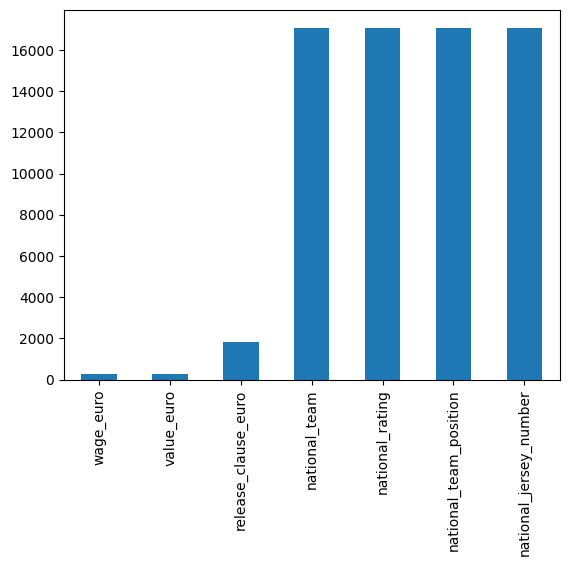

In [138]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values.sort_values(inplace=True)
missing_values.plot.bar()

In [139]:
df.drop(['national_team', 'national_team_position','national_rating', 
         'national_jersey_number'], axis=1, inplace=True)

In [140]:
missing_cols = df.columns[df.isnull().any()]
df[missing_cols].isnull().sum()

value_euro              255
wage_euro               246
release_clause_euro    1837
dtype: int64

## Histogram

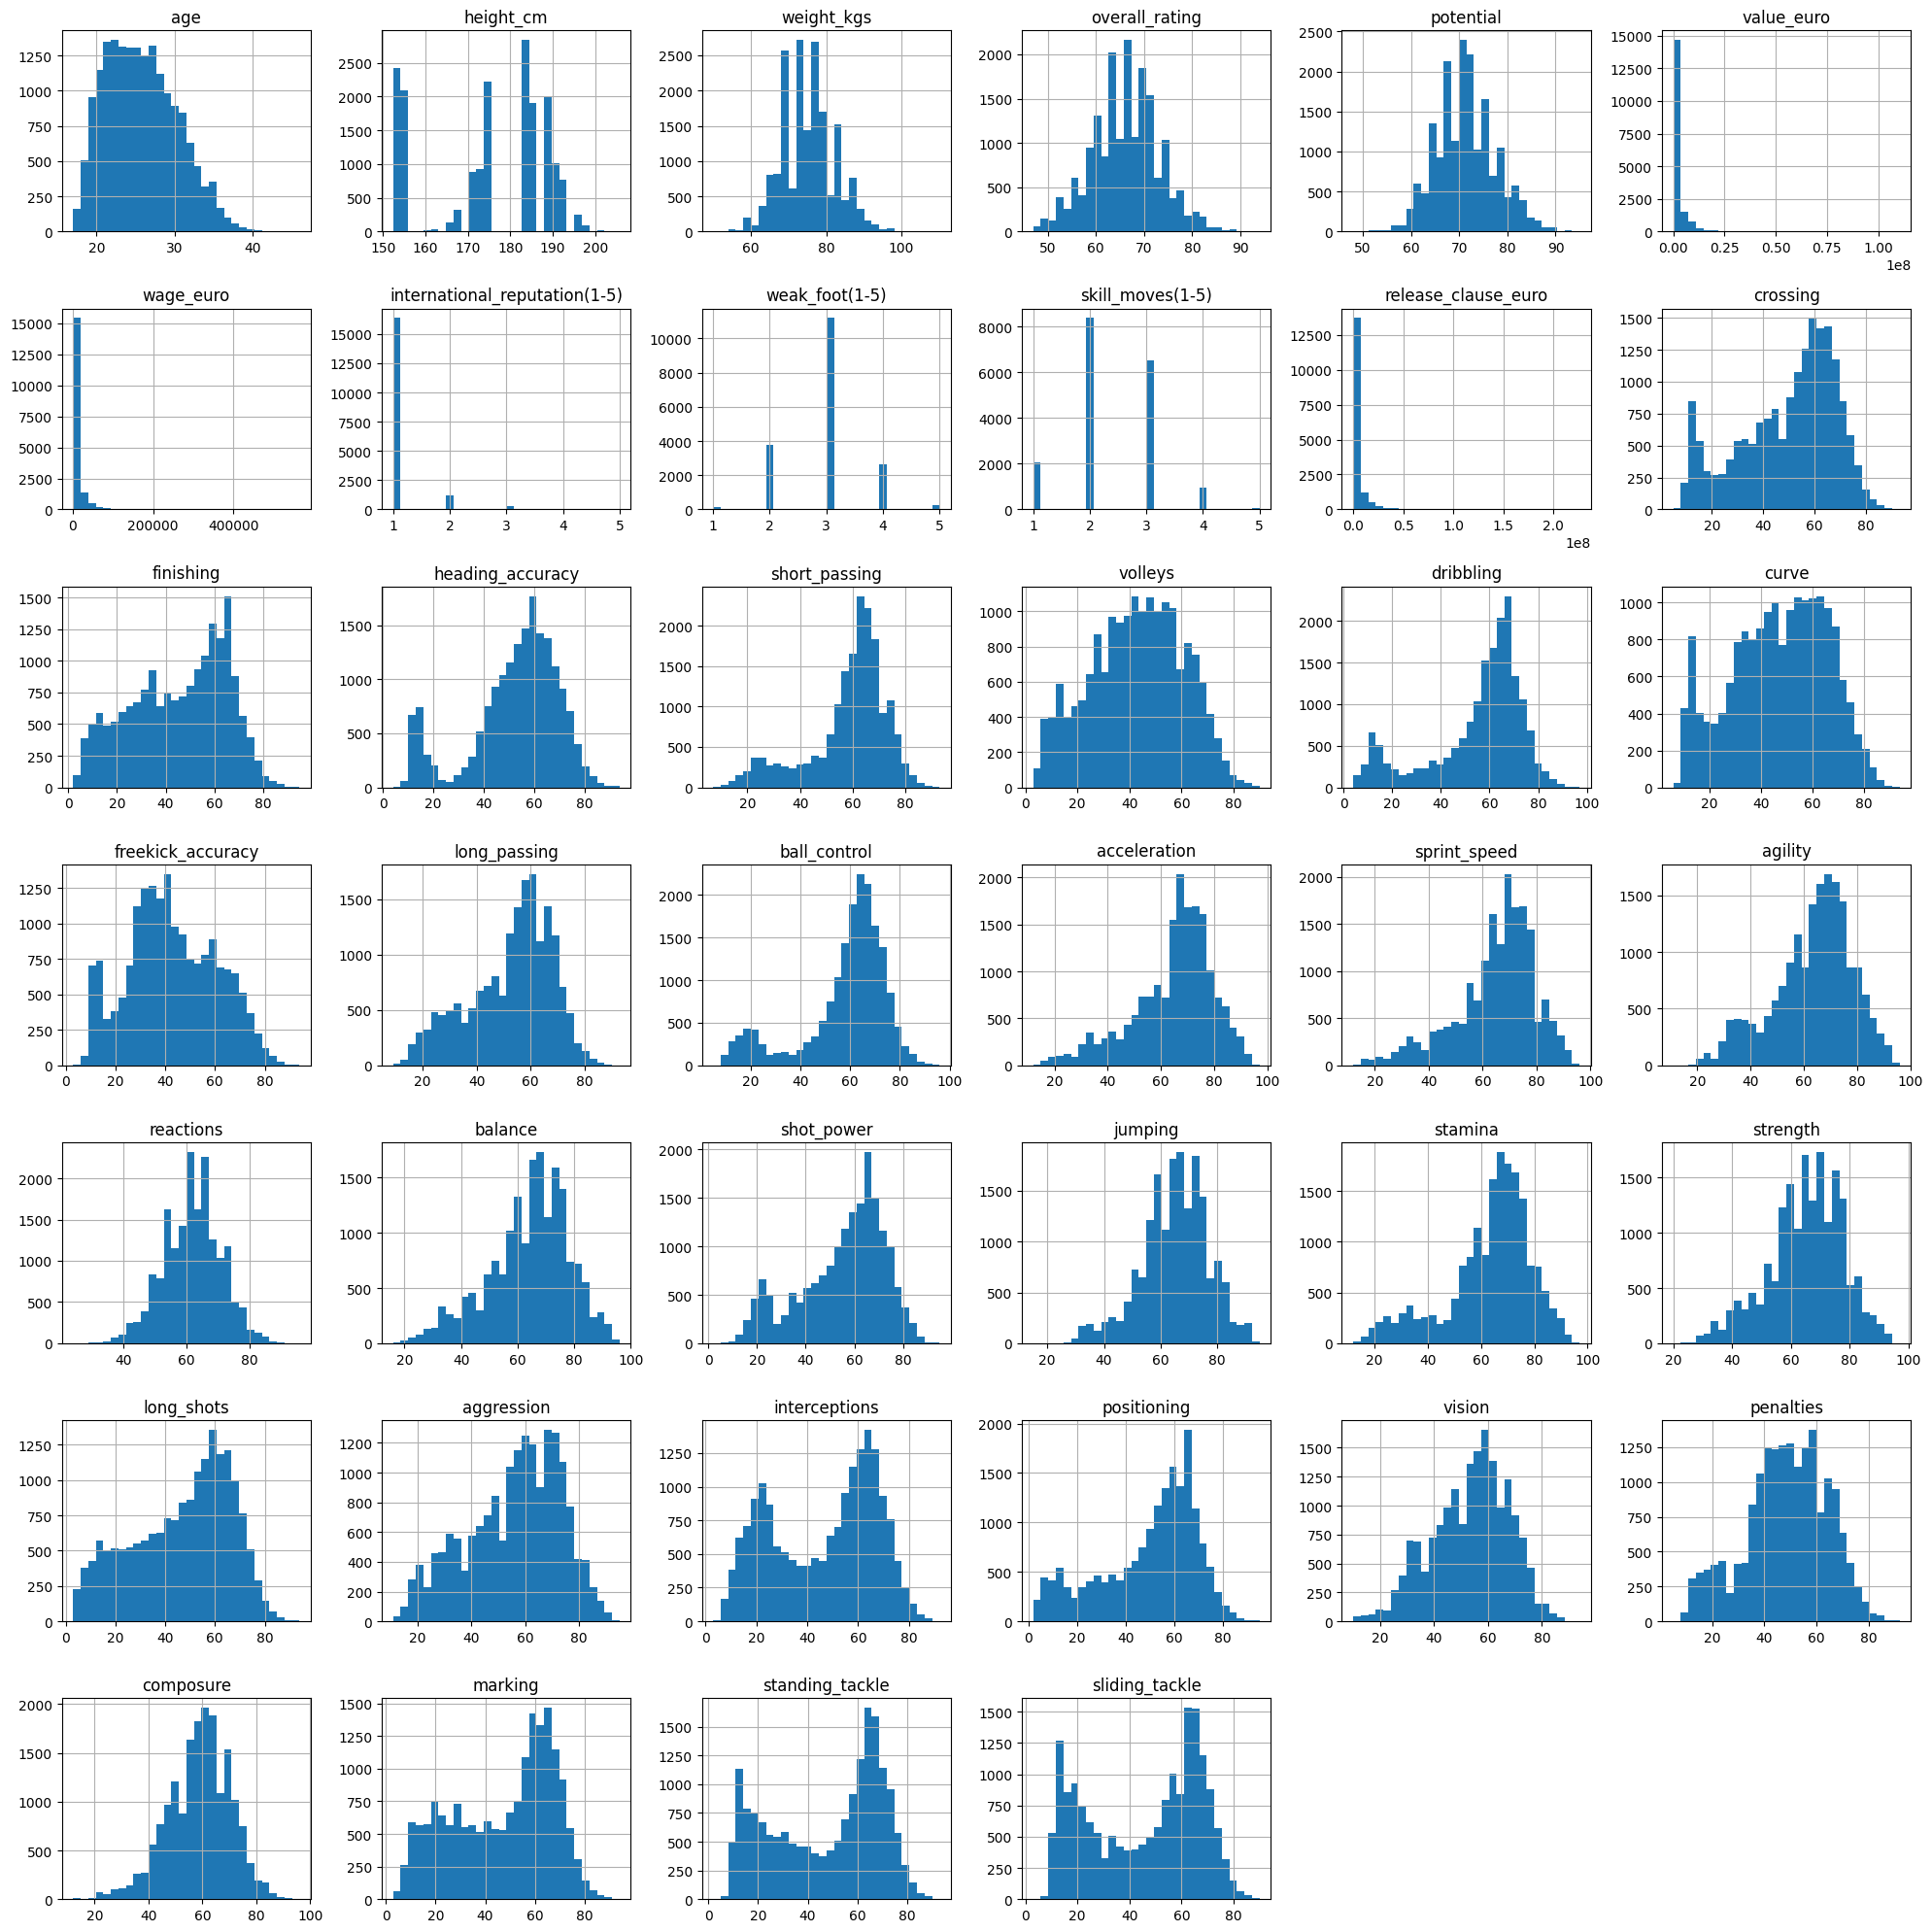

In [141]:
df.hist(bins=30, figsize=(20,20))
plt.tight_layout()
plt.show()

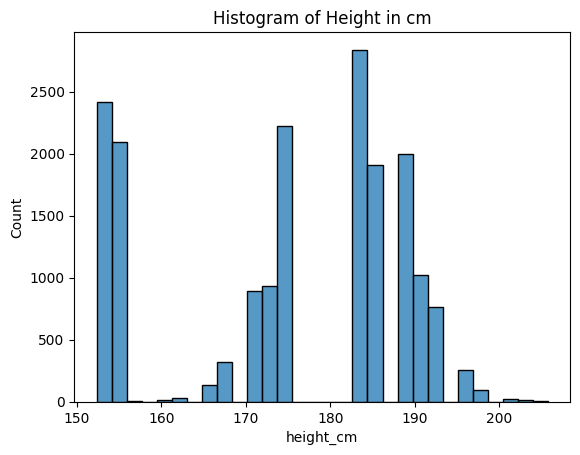

In [142]:
sns.histplot(df['height_cm'], bins=30)
plt.title('Histogram of Height in cm')
plt.show()

In [143]:
height_outliers = df[df['height_cm'] <= 160]
height_outliers = height_outliers[['height_cm']]
height_outliers

,height_cm
id,
1,154.94
6,152.40
15,152.40
17,152.40
29,154.94
...,...
17906,154.94
17910,154.94
17926,154.94


In [144]:
df[df['height_cm'] <= 160].shape

(4515, 44)

In [145]:
df.loc[df['height_cm'] <= 160, 'height_cm'] = np.nan

In [146]:
df.isnull().sum().sort_values(ascending=False)

height_cm                        4515
release_clause_euro              1837
value_euro                        255
wage_euro                         246
positions                           0
weight_kgs                          0
overall_rating                      0
nationality                         0
potential                           0
preferred_foot                      0
international_reputation(1-5)       0
age                                 0
weak_foot(1-5)                      0
skill_moves(1-5)                    0
body_type                           0
crossing                            0
finishing                           0
heading_accuracy                    0
short_passing                       0
volleys                             0
dribbling                           0
curve                               0
freekick_accuracy                   0
long_passing                        0
ball_control                        0
acceleration                        0
sprint_speed

## Miss Forest for handling height ouliers

In [147]:
from missforest import MissForest

imputer = MissForest()

columns_to_impute = ['value_euro', 'height_cm', 'wage_euro', 'release_clause_euro']

df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

df[columns_to_impute].isnull().sum()

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:01<00:00,  4.82it/s]


value_euro             0
height_cm              0
wage_euro              0
release_clause_euro    0
dtype: int64

<Axes: >

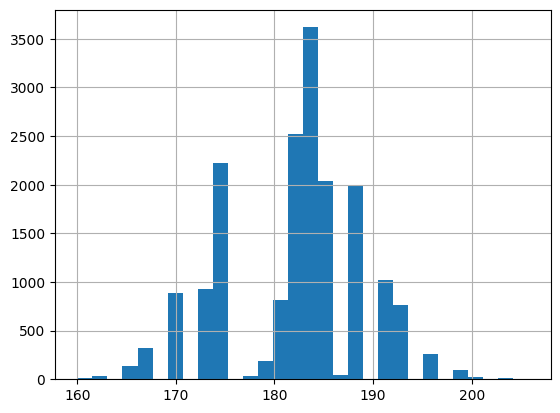

In [148]:
df['height_cm'].hist(bins=30)

<Axes: >

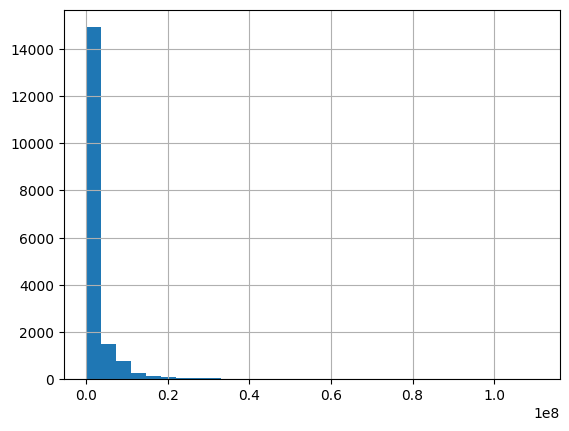

In [149]:
df['value_euro'].hist(bins=30)

<Axes: >

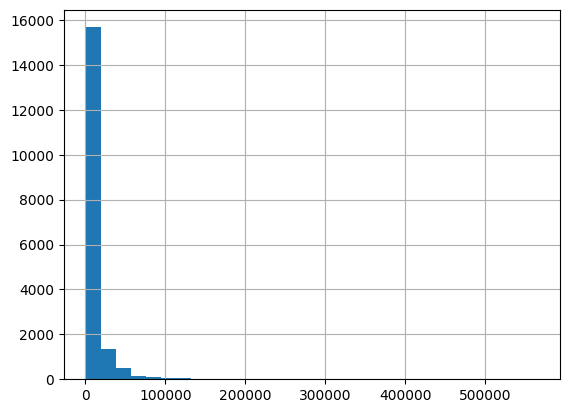

In [150]:
df['wage_euro'].hist(bins=30)

## Check duplicated values

In [151]:
df.duplicated().sum()

np.int64(0)

## Handle String values

In [152]:
object_cols = df.select_dtypes(include=['object']).columns
df[object_cols].nunique()

positions         890
nationality       160
preferred_foot      2
body_type          10
dtype: int64

In [153]:
for col in object_cols:
    print(f'{col}: {df[col].unique()}')
    print()

positions: ['CF,RW,ST' 'CAM,RM,CM' 'CM,CAM' 'LW,ST' 'CB' 'RW,ST,RM' 'ST' 'GK'
 'CDM,CM' 'CF,ST' 'RW,ST' 'CAM,RW' 'CDM' 'CM,CDM' 'LB' 'CM,CAM,CDM'
 'CAM,CM,LW' 'CAM,CM,RM' 'LW,ST,LM' 'CAM,CM' 'CAM' 'LW,RW' 'RW,LW' 'CM,LM'
 'CM' 'RM,RW' 'LM,RM,CAM,LW' 'LM' 'RW,RM' 'LM,ST,RM' 'RB' 'LM,RM,LW,RW'
 'LM,CAM,RM' 'RM,LM,ST' 'RW' 'LM,ST,RM,LW' 'CM,CDM,CAM' 'CM,CDM,CB'
 'CB,CDM' 'CF,ST,CAM' 'CDM,CB' 'RB,RWB' 'RM' 'LM,CAM' 'CM,LW' 'LB,LWB,LM'
 'ST,LW' 'LM,LB,CM' 'RB,RM' 'RM,LM,CM' 'LM,RM,CAM' 'RM,RW,ST' 'LW,LM,RW'
 'LB,LM' 'ST,LW,LM' 'RM,CM' 'CM,RM' 'CB,RB' 'RM,RW,LM' 'LM,RM' 'CDM,CB,CM'
 'CAM,CDM' 'LB,CDM' 'CAM,RM,LM' 'RM,CAM,CM' 'LWB' 'CDM,CM,LM' 'CDM,CM,RM'
 'CDM,CM,CB' 'CAM,LW' 'RM,LM' 'ST,CAM' 'LM,CM' 'ST,CF,CAM,LM'
 'LWB,LB,CB,LM' 'RB,LB' 'LW' 'CAM,ST' 'LM,RM,LW' 'LWB,LM,LB'
 'ST,CF,LM,CAM' 'LM,LW,ST' 'LB,LWB' 'RWB,RB,RM' 'ST,RW' 'CAM,CM,LM'
 'RB,RW' 'RM,CAM,LM' 'ST,RM' 'RM,ST' 'CM,LM,RM' 'CM,CAM,LM' 'RW,RWB'
 'LM,RB' 'RM,LM,RW,CAM' 'ST,RM,RWB,LM' 'LB,RB' 'CM,CDM,RM' 'LM,LW'
 'CAM,ST,RM' 'ST

In [154]:
valid_body_types = ['Lean', 'Normal', 'Stocky']
df = df[df['body_type'].isin(valid_body_types)]
df['body_type'].unique()

array(['Lean', 'Normal', 'Stocky'], dtype=object)

In [155]:
df['body_type'].value_counts()

body_type
Normal    10393
Lean       6468
Stocky     1086
Name: count, dtype: int64

In [156]:
df['preferred_foot'].value_counts()

preferred_foot
Right    13778
Left      4169
Name: count, dtype: int64

In [157]:
df['international_reputation(1-5)'].value_counts()

international_reputation(1-5)
1    16369
2     1226
3      299
4       50
5        3
Name: count, dtype: int64

In [158]:
df.drop(['international_reputation(1-5)'], axis=1, inplace=True)

## preferred foot

In [159]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df['preferred_foot'] = le.fit_transform(df['preferred_foot'])
df['preferred_foot'].value_counts()

preferred_foot
1    13778
0     4169
Name: count, dtype: int64

## body type

In [160]:
df_encoded = pd.get_dummies(df, columns=['body_type'])
df_encoded.head()

,age,height_cm,weight_kgs,positions,nationality,overall_rating,potential,value_euro,wage_euro,preferred_foot,weak_foot(1-5),skill_moves(1-5),release_clause_euro,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,freekick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle,body_type_Lean,body_type_Normal,body_type_Stocky
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,27,177.606642,76.2,"CAM,RM,CM",Denmark,88,89,69500000.0,205000.0,1,5,4,133800000.0,88,81,52,91,80,84,86,87,89,91,76,73,80,88,81,84,50,92,58,89,46,56,84,91,67,88,59,57,22,True,False,False
2,25,190.500000,83.9,"CM,CAM",France,88,91,73000000.0,255000.0,1,4,5,144200000.0,80,75,75,86,85,87,85,82,90,90,71,79,76,82,66,90,83,88,87,82,78,64,82,88,82,87,63,67,67,False,True,False
3,27,162.560000,59.0,"LW,ST",Italy,88,88,62000000.0,165000.0,1,4,4,105400000.0,86,77,56,85,74,90,87,77,78,93,94,86,94,83,93,75,53,75,44,84,34,26,83,87,61,83,51,24,22,False,True,False
4,27,187.960000,88.9,CB,Senegal,88,91,60000000.0,135000.0,1,3,2,106500000.0,30,22,83,68,14,69,28,28,60,63,70,75,50,82,40,55,81,75,94,15,87,88,24,49,33,80,91,88,87,False,True,False
5,27,193.040000,92.1,CB,Netherlands,88,90,59500000.0,215000.0,1,3,2,114500000.0,53,52,83,79,45,70,60,70,81,76,74,77,61,87,49,81,88,75,92,64,82,88,41,60,62,87,90,89,84,False,True,False


In [161]:
df = df_encoded.copy()

## positions

In [162]:
object_cols = df.select_dtypes(include=['object']).columns
object_cols

Index(['positions', 'nationality'], dtype='object')

In [163]:
df['positions'] = df['positions'].str.split(',')
df['positions']

id
1        [CAM, RM, CM]
2            [CM, CAM]
3             [LW, ST]
4                 [CB]
5                 [CB]
             ...      
17949    [RM, CAM, CM]
17950             [LB]
17951             [GK]
17952         [ST, LM]
17953             [ST]
Name: positions, Length: 17947, dtype: object

In [164]:
df_exploded = df.explode('positions')
df_encoded = pd.get_dummies(df_exploded, columns=['positions'])

one_hot_columns = [col for col in df_encoded.columns if col.startswith('positions_')]
df_one_hot_sum = df_encoded[one_hot_columns].groupby('id').sum()
df_final = df.drop(columns=['positions']).join(df_one_hot_sum)

df = df_final

In [165]:
import pandas as pd
pd.set_option('display.max_columns', None)
df.head()

,age,height_cm,weight_kgs,nationality,overall_rating,potential,value_euro,wage_euro,preferred_foot,weak_foot(1-5),skill_moves(1-5),release_clause_euro,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,freekick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle,body_type_Lean,body_type_Normal,body_type_Stocky,positions_CAM,positions_CB,positions_CDM,positions_CF,positions_CM,positions_GK,positions_LB,positions_LM,positions_LW,positions_LWB,positions_RB,positions_RM,positions_RW,positions_RWB,positions_ST
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,27,177.606642,76.2,Denmark,88,89,69500000.0,205000.0,1,5,4,133800000.0,88,81,52,91,80,84,86,87,89,91,76,73,80,88,81,84,50,92,58,89,46,56,84,91,67,88,59,57,22,True,False,False,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,25,190.500000,83.9,France,88,91,73000000.0,255000.0,1,4,5,144200000.0,80,75,75,86,85,87,85,82,90,90,71,79,76,82,66,90,83,88,87,82,78,64,82,88,82,87,63,67,67,False,True,False,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,27,162.560000,59.0,Italy,88,88,62000000.0,165000.0,1,4,4,105400000.0,86,77,56,85,74,90,87,77,78,93,94,86,94,83,93,75,53,75,44,84,34,26,83,87,61,83,51,24,22,False,True,False,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,27,187.960000,88.9,Senegal,88,91,60000000.0,135000.0,1,3,2,106500000.0,30,22,83,68,14,69,28,28,60,63,70,75,50,82,40,55,81,75,94,15,87,88,24,49,33,80,91,88,87,False,True,False,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5,27,193.040000,92.1,Netherlands,88,90,59500000.0,215000.0,1,3,2,114500000.0,53,52,83,79,45,70,60,70,81,76,74,77,61,87,49,81,88,75,92,64,82,88,41,60,62,87,90,89,84,False,True,False,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


# nationality

In [166]:
object_cols = df.select_dtypes(include=['object']).columns
object_cols

Index(['nationality'], dtype='object')

In [167]:
df['nationality'].nunique()

160

In [168]:
df['nationality'].unique()

array(['Denmark', 'France', 'Italy', 'Senegal', 'Netherlands',
       'Argentina', 'Germany', 'Uruguay', 'Spain', 'Slovakia', 'Brazil',
       'Croatia', 'Belgium', 'Costa Rica', 'Colombia', 'Morocco',
       'Portugal', 'Sweden', 'Bosnia Herzegovina', 'Mexico', 'England',
       'Austria', 'Iceland', 'Hungary', 'Wales', 'Ukraine',
       'Central African Rep.', 'Serbia', 'Ivory Coast', 'Cameroon',
       'Paraguay', 'Australia', 'Algeria', 'Romania', 'Russia', 'Israel',
       'Switzerland', 'Chile', 'Tunisia', 'Turkey', 'Nigeria', 'Peru',
       'Norway', 'Greece', 'United States', 'Venezuela', 'Iran', 'Egypt',
       'Equatorial Guinea', 'Cape Verde', 'Tanzania', 'Scotland',
       'China PR', 'Kosovo', 'Montenegro', 'Canada', 'Madagascar', 'Mali',
       'Ghana', 'Guinea', 'Poland', 'Cuba', 'Northern Ireland', 'Japan',
       'New Zealand', 'South Africa', 'Republic of Ireland', 'Ecuador',
       'Burkina Faso', 'Czech Republic', 'Slovenia', 'Belarus', 'Gabon',
       'FYR Macedoni

In [169]:
df['nationality'].value_counts()

nationality
England                 1657
Germany                 1199
Spain                   1070
France                   925
Argentina                903
                        ... 
Kuwait                     1
New Caledonia              1
Oman                       1
São Tomé & Príncipe        1
United Arab Emirates       1
Name: count, Length: 160, dtype: int64

# Create new data

In [170]:
df.to_csv('data.csv', index=False)

# Leakage Problem

In [171]:
import pandas as pd

df = pd.read_csv('data.csv')

In [172]:
tmp = df.drop('nationality', axis=1)
tmp.corr()['overall_rating'].sort_values(ascending=False)

overall_rating         1.000000
reactions              0.855256
composure              0.728691
potential              0.645983
value_euro             0.632959
release_clause_euro    0.619706
wage_euro              0.580958
short_passing          0.506723
vision                 0.506109
long_passing           0.489709
ball_control           0.464033
age                    0.461795
shot_power             0.444950
long_shots             0.428871
curve                  0.423272
skill_moves(1-5)       0.417659
freekick_accuracy      0.400147
aggression             0.398159
crossing               0.398009
volleys                0.396200
dribbling              0.378291
stamina                0.368837
positioning            0.361473
strength               0.361342
penalties              0.350288
heading_accuracy       0.348068
finishing              0.341444
interceptions          0.323453
marking                0.294158
agility                0.274225
jumping                0.271111
standing

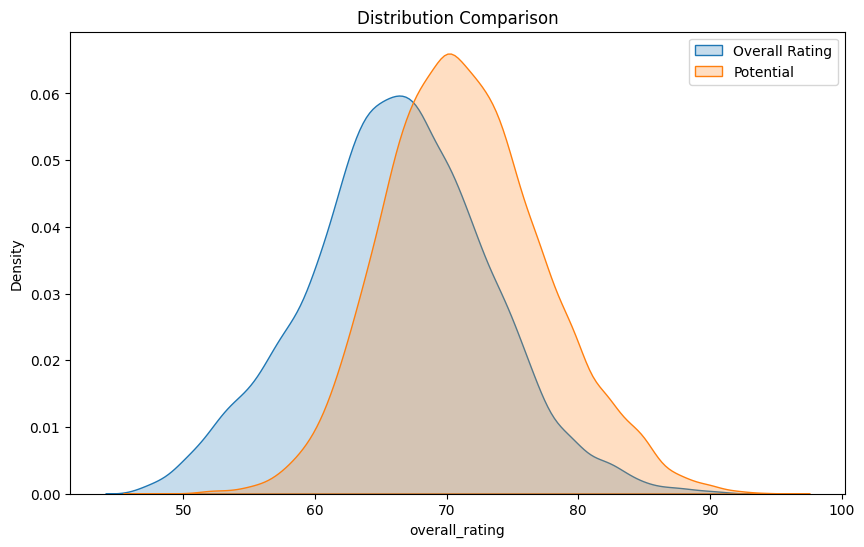

In [173]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.kdeplot(df['overall_rating'], label="Overall Rating", fill=True)
sns.kdeplot(df['potential'], label="Potential", fill=True)
plt.legend()
plt.title("Distribution Comparison")
plt.show()

In [174]:
df.drop(['value_euro', 'wage_euro', 'release_clause_euro',
         'potential', 'composure', 'reactions'], axis=1, inplace=True)

## Handle outliers

In [175]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

exclude_columns = ['positions_CAM', 'positions_CB', 'positions_CDM', 'positions_CF', 'positions_CM', 'positions_GK', 
                   'positions_LB', 'positions_LM', 'positions_LW', 'positions_LWB', 'positions_RB', 'positions_RM', 
                   'positions_RW', 'positions_RWB', 'positions_ST', 'body_type_Lean', 'body_type_Normal', 'body_type_Stocky',
                   'overall_rating', 'preferred_foot', 'weak_foot(1-5)']

In [176]:
from typing import Tuple
from sklearn.base import BaseEstimator, TransformerMixin


def find_boxplot_boundaries(
    col: pd.Series, whisker_coeff: float = 1.5
) -> Tuple[float, float]:
    """Findx minimum and maximum in boxplot.

    Args:
        col: a pandas serires of input.
        whisker_coeff: whisker coefficient in box plot
    """
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - whisker_coeff * IQR
    upper = Q3 + whisker_coeff * IQR
    return lower, upper


class BoxplotOutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, whisker_coeff: float = 1.5):
        self.whisker = whisker_coeff
        self.lower = None
        self.upper = None

    def fit(self, X: pd.Series):
        self.lower, self.upper = find_boxplot_boundaries(X, self.whisker)
        return self

    def transform(self, X):
        return X.clip(self.lower, self.upper)

In [177]:
outlier_features = []

for column in numeric_columns:
    if column not in exclude_columns:
        clipper = BoxplotOutlierClipper()
        clipper.fit(df[column])
        lower, upper = clipper.lower, clipper.upper
        if df[(df[column] < lower) | (df[column] > upper)].shape[0] > 0:
            outlier_features.append(column)

print("Features with outliers:", outlier_features)

Features with outliers: ['age', 'height_cm', 'weight_kgs', 'skill_moves(1-5)', 'heading_accuracy', 'short_passing', 'dribbling', 'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'agility', 'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'vision']


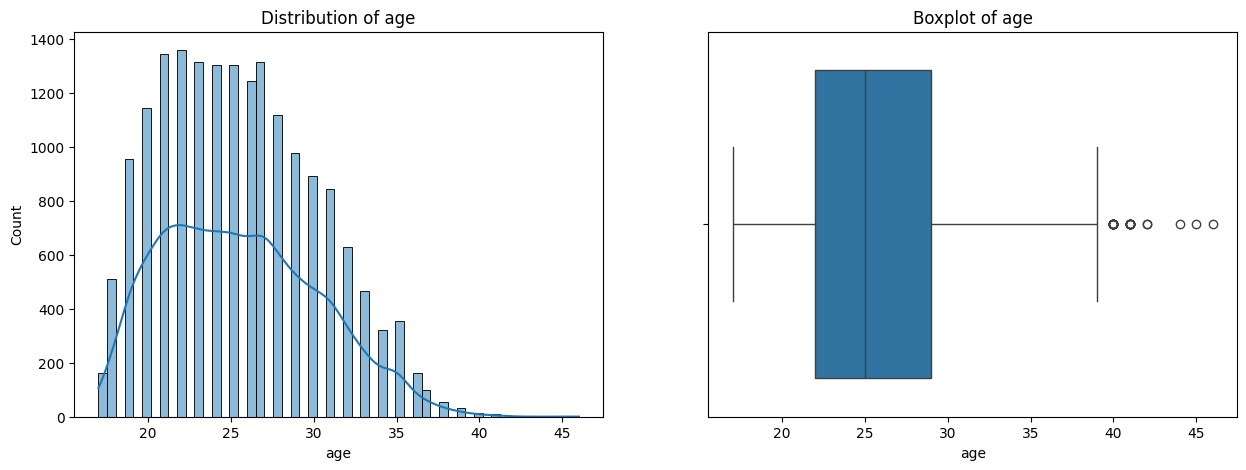

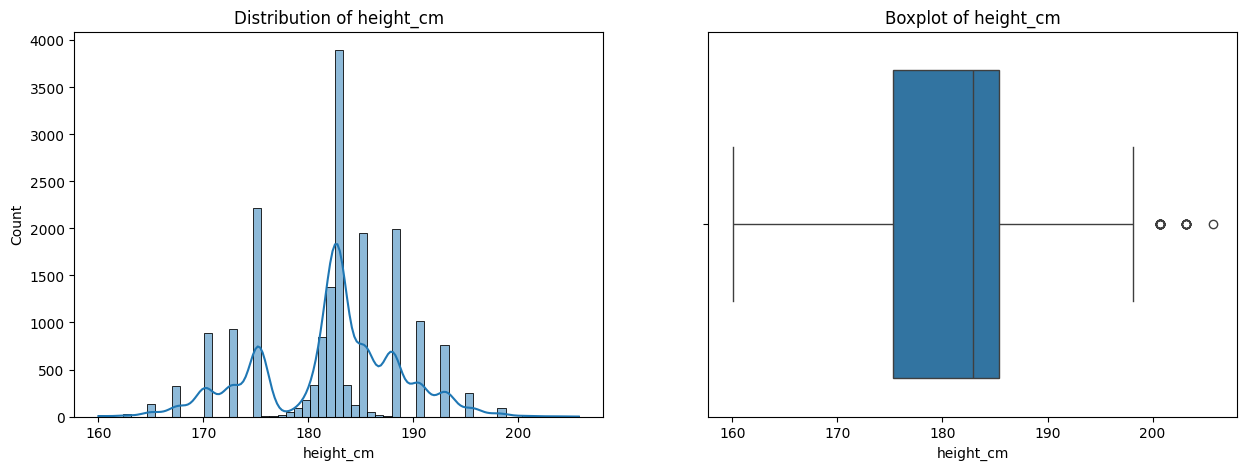

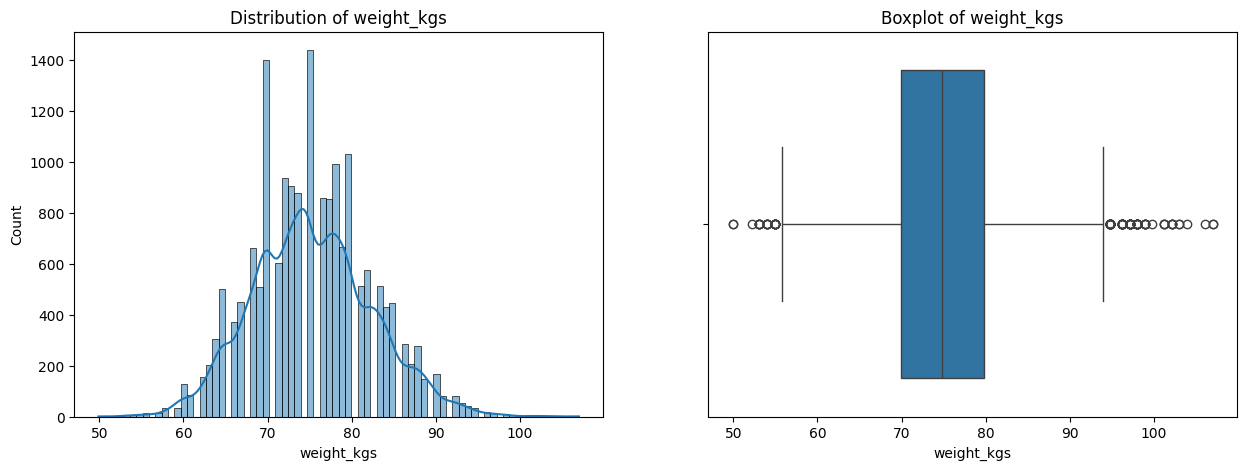

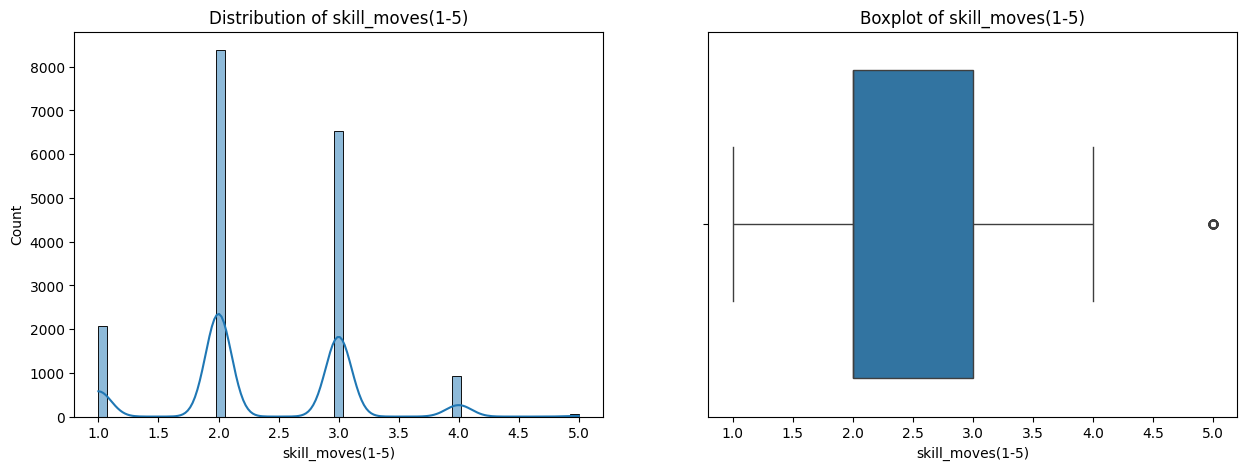

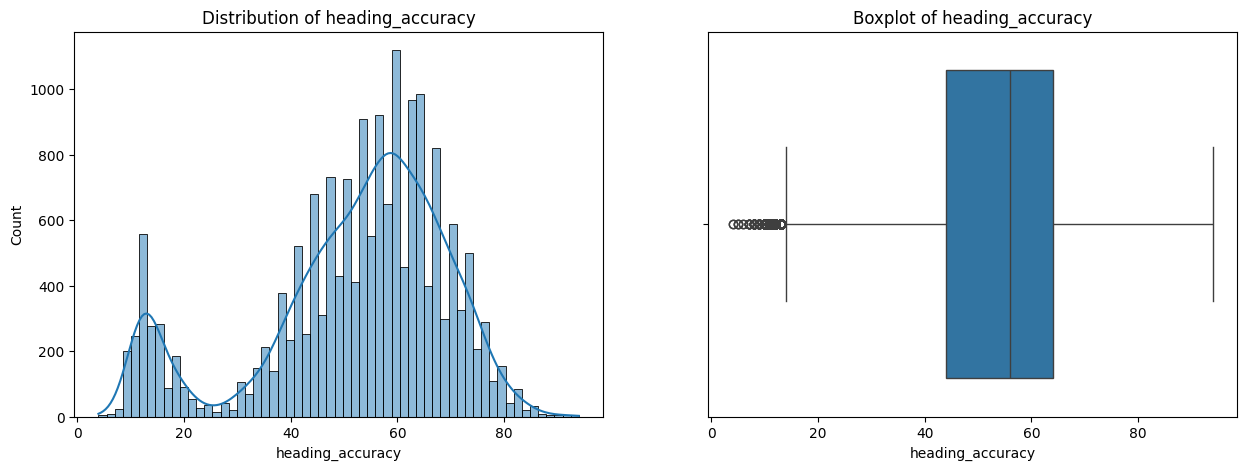

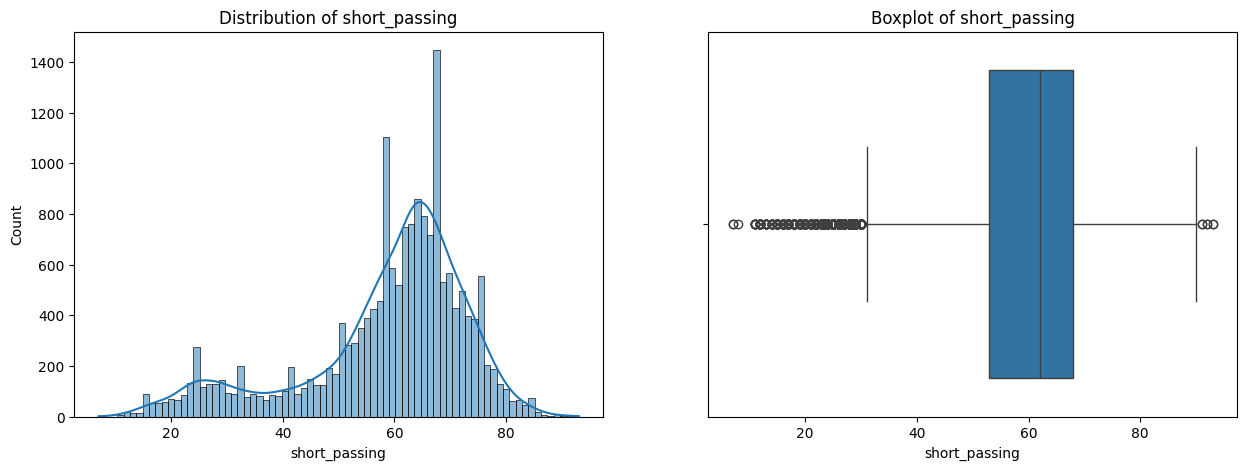

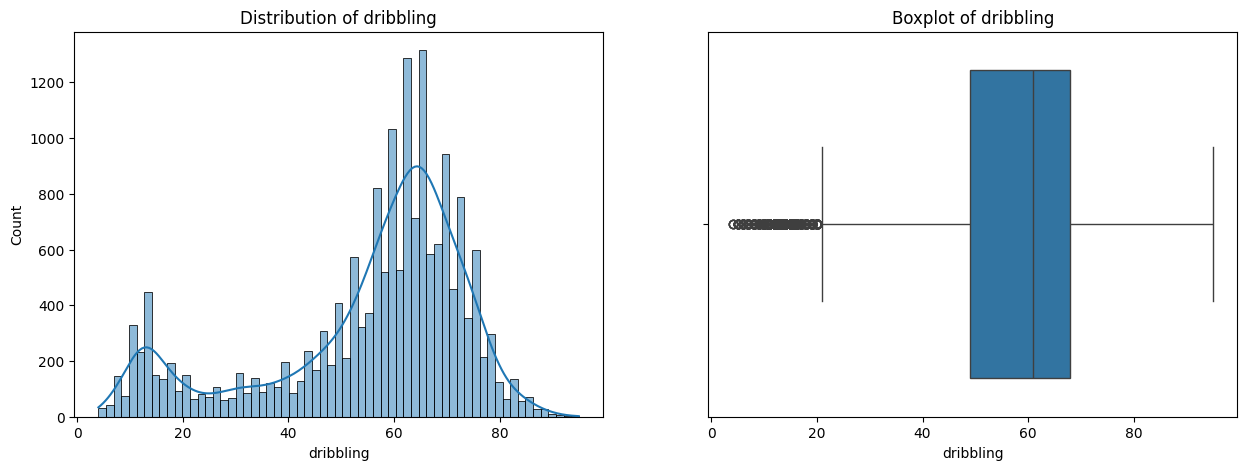

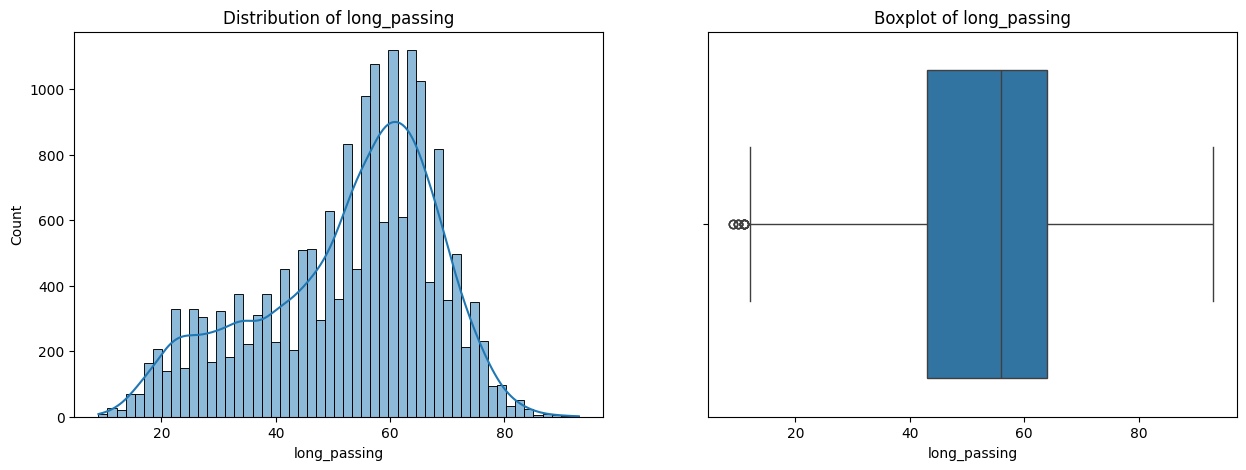

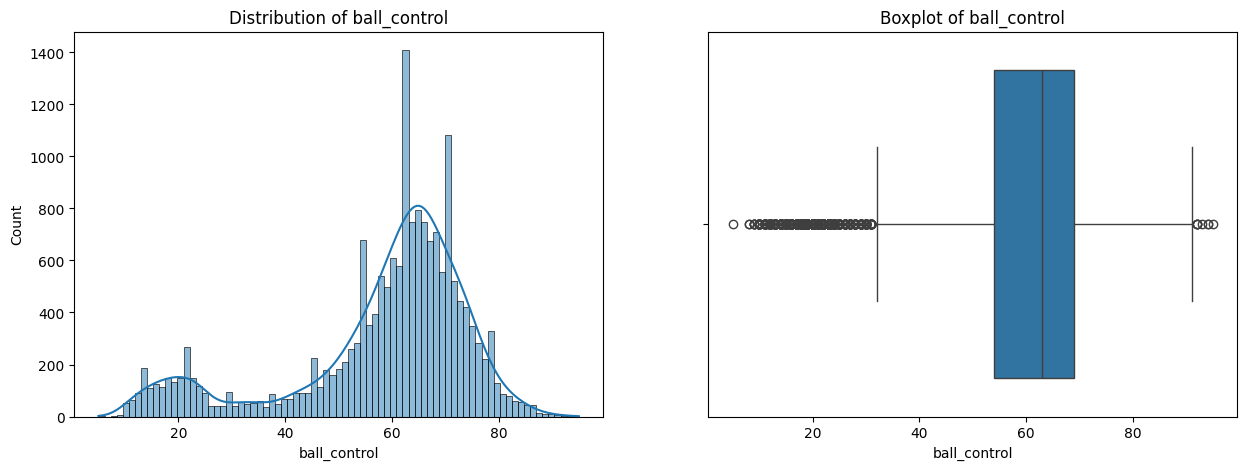

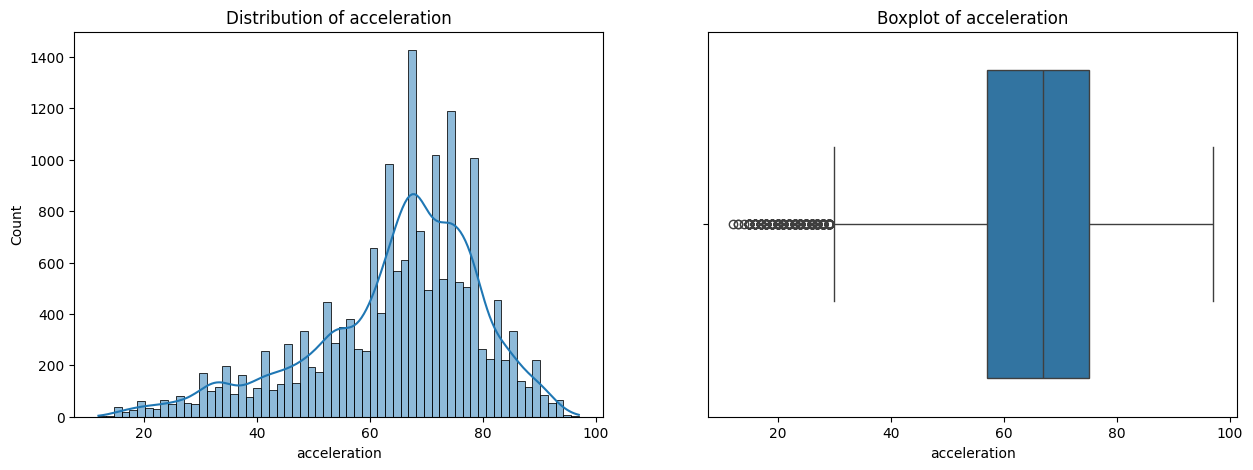

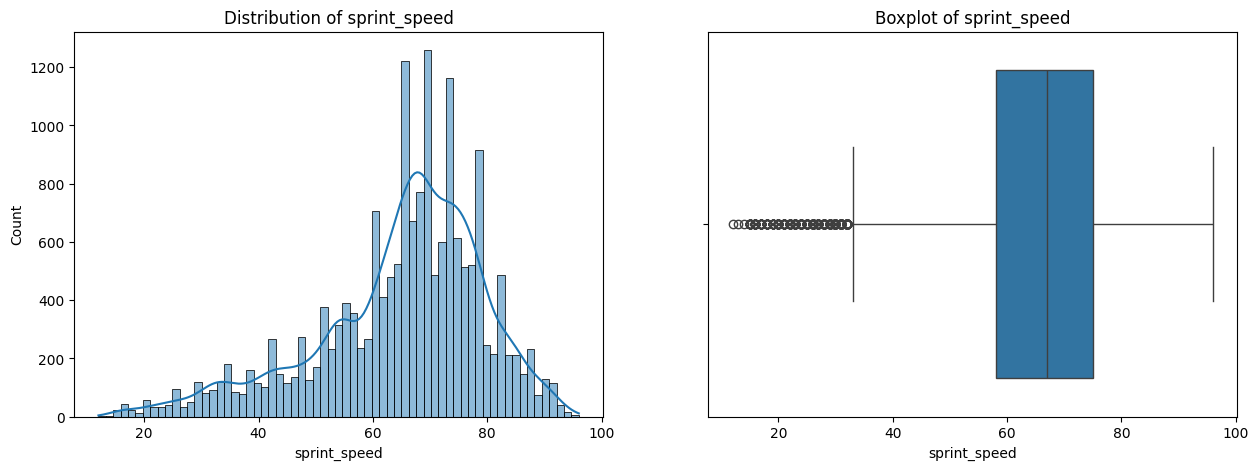

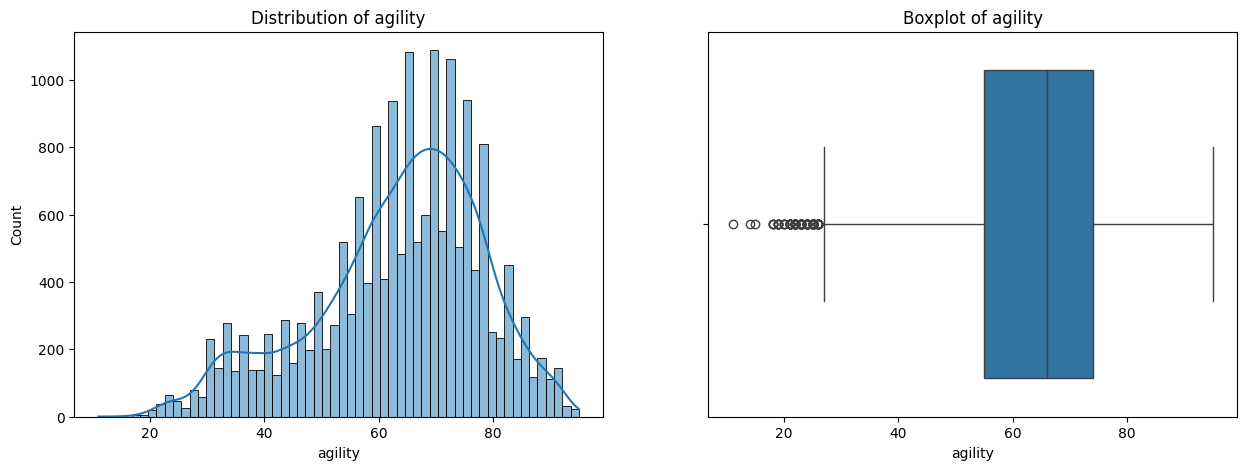

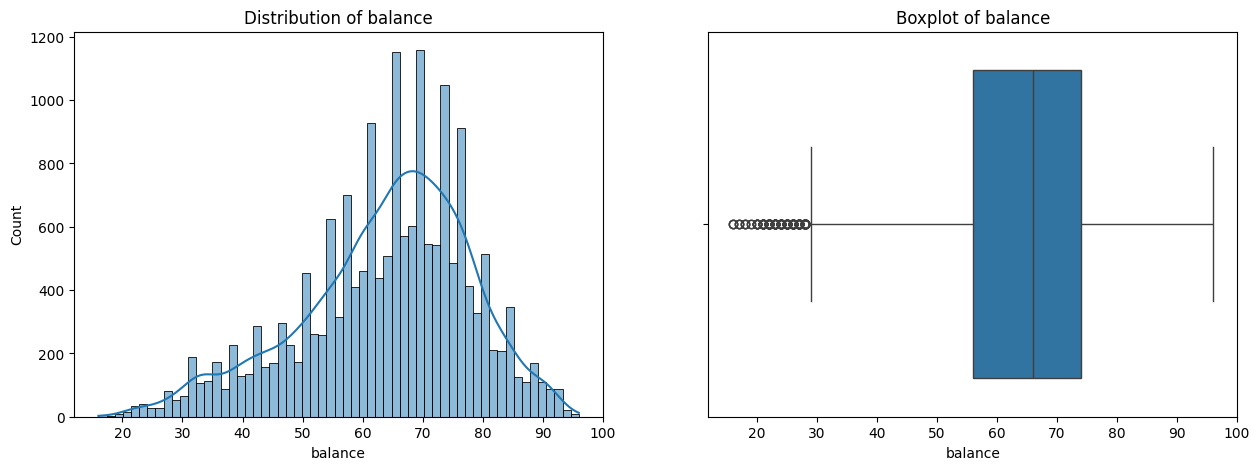

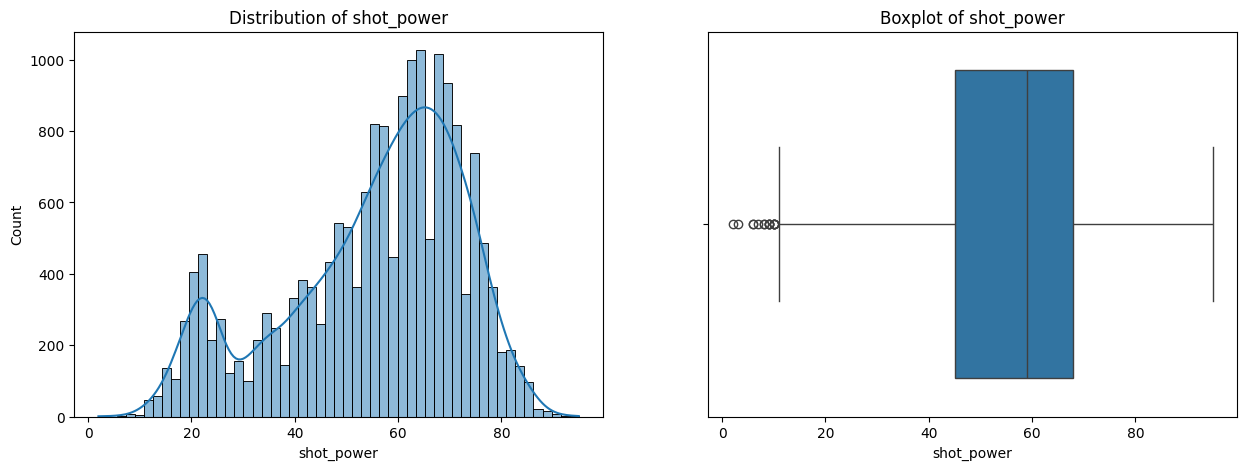

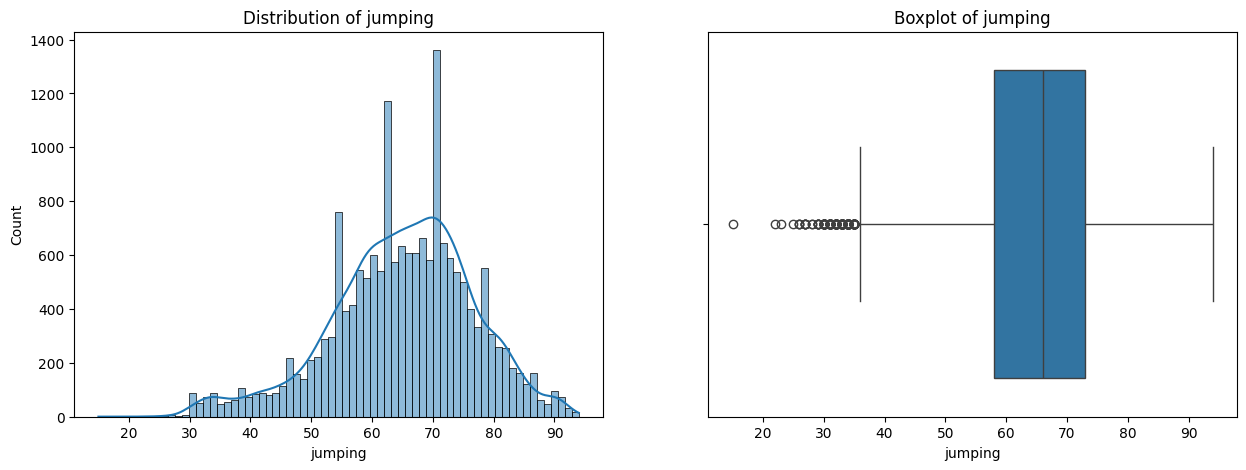

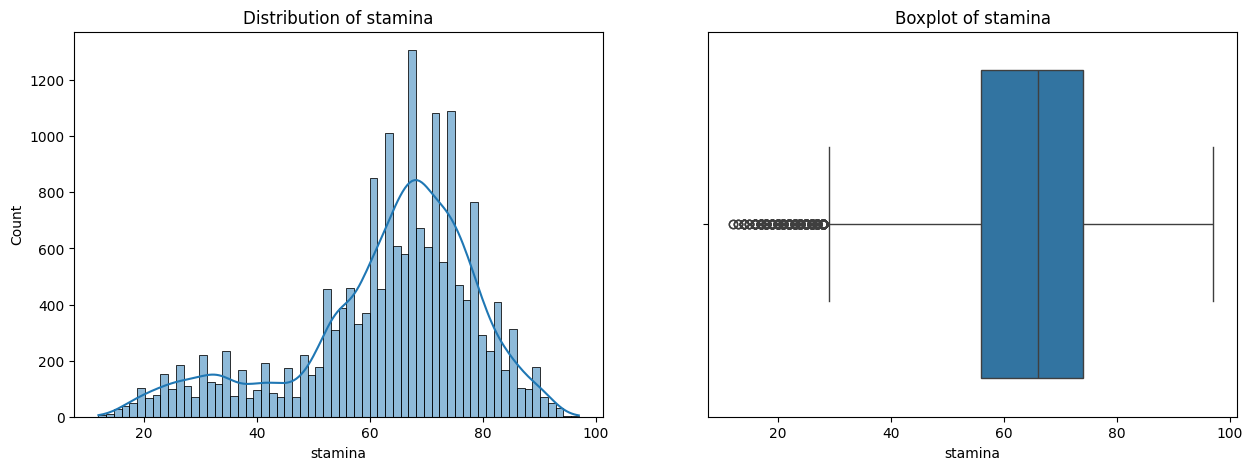

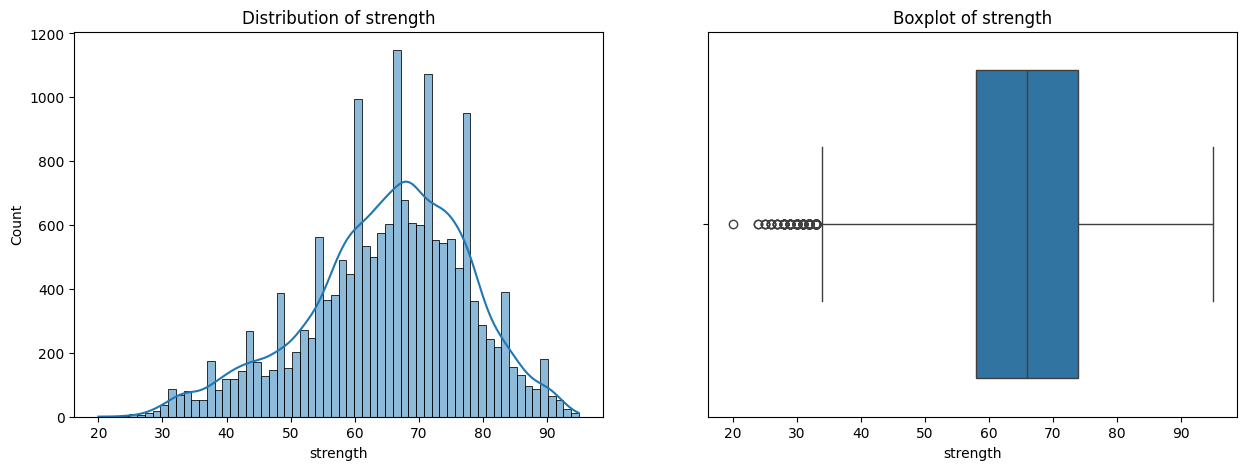

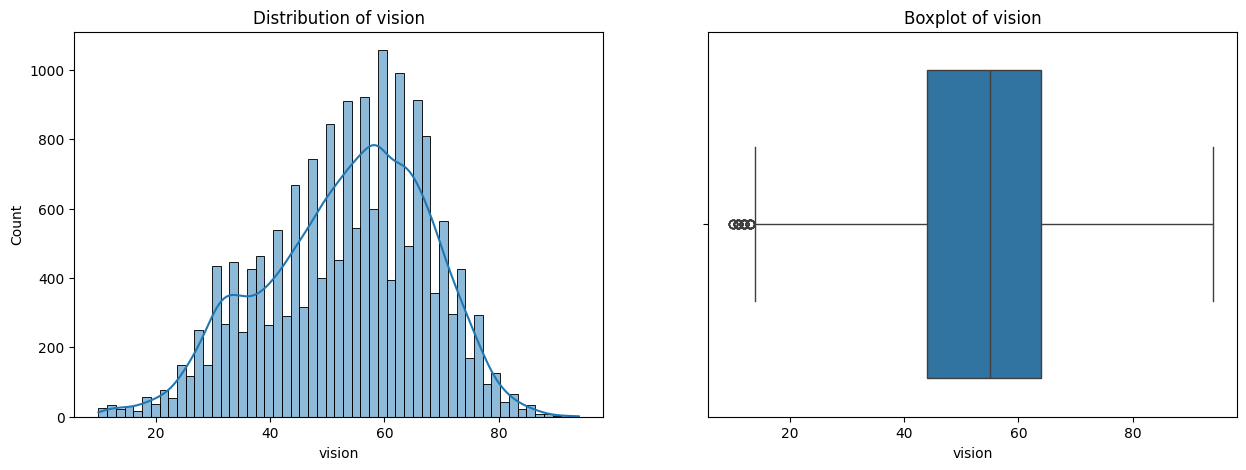

In [178]:
for column in outlier_features:
    if column in exclude_columns:
        continue
    plt.figure(figsize=(15, 5))
    
    # Distribution plot
    plt.subplot(1, 2, 1)
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
    
    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')
    
    plt.show()

In [179]:
for feature in outlier_features:
    clipper = BoxplotOutlierClipper()
    df[feature] = clipper.fit_transform(df[feature])

df.head()

,age,height_cm,weight_kgs,nationality,overall_rating,preferred_foot,weak_foot(1-5),skill_moves(1-5),crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,freekick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,body_type_Lean,body_type_Normal,body_type_Stocky,positions_CAM,positions_CB,positions_CDM,positions_CF,positions_CM,positions_GK,positions_LB,positions_LM,positions_LW,positions_LWB,positions_RB,positions_RM,positions_RW,positions_RWB,positions_ST
0,27.0,177.606642,76.2,Denmark,88,1,5,4.0,88,81,52,90.5,80,84.0,86,87,89.0,91.0,76,73.0,80.0,81,84.0,50.0,92,58,89,46,56,84,91,67,59,57,22,True,False,False,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1,25.0,190.500000,83.9,France,88,1,4,4.5,80,75,75,86.0,85,87.0,85,82,90.0,90.0,71,79.0,76.0,66,90.0,83.0,88,87,82,78,64,82,88,82,63,67,67,False,True,False,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,27.0,162.560000,59.0,Italy,88,1,4,4.0,86,77,56,85.0,74,90.0,87,77,78.0,91.5,94,86.0,94.0,93,75.0,53.0,75,44,84,34,26,83,87,61,51,24,22,False,True,False,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,27.0,187.960000,88.9,Senegal,88,1,3,2.0,30,22,83,68.0,14,69.0,28,28,60.0,63.0,70,75.0,50.0,40,55.0,81.0,75,94,15,87,88,24,49,33,91,88,87,False,True,False,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,27.0,193.040000,92.1,Netherlands,88,1,3,2.0,53,52,83,79.0,45,70.0,60,70,81.0,76.0,74,77.0,61.0,49,81.0,88.0,75,92,64,82,88,41,60,62,90,89,84,False,True,False,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [180]:
df.to_csv('data.csv', index=False)

In [181]:
# from category_encoders import TargetEncoder
# from sklearn.model_selection import train_test_split

# te = TargetEncoder(cols=['naionality'])

# X = df.drop('overall_rating', axis=1)
# y = df['overall_rating']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# X_train = te.fit_transform(X_train, y_train)
# X_test = te.transform(X_test)

# X_train['overall_rating'] = y_train
# X_test['overall_rating'] = y_test

# encoded_df = pd.concat([X_train, X_test], axis=0)

# encoded_df = encoded_df.sort_index()

# # Save to new CSV file
# encoded_df.to_csv('data_encoded.csv', index=False)